## Steady-state Single Variable Analysis

In [ ]:
import trenchripper.trenchripper as tr

import dask
import warnings
import random
import anndata

import numpy as np
import pandas as pd
import dask.dataframe as dd

from matplotlib import pyplot as plt

random.seed(42)
np.random.seed(42)

warnings.filterwarnings(action='once',category=UserWarning)

# addition of active memory manager
dask.config.set({'distributed.scheduler.active-memory-manager.start': True});
dask.config.set({'distributed.scheduler.worker-ttl': "5m"});
dask.config.set({'distributed.scheduler.allowed-failures': 100});

dask_wd = "/home/de64/scratch/de64/dask"

### Initial Data Processing

#### Start Dask

In [4]:
dask_controller = tr.trcluster.dask_controller(
    walltime="01:00:00",
    local=False,
    n_workers=25,
    n_workers_min=25,
    memory="16GB",
    working_directory=dask_wd,
)
dask_controller.startdask()

50m
01:00:00


In [6]:
dask_controller.daskclient

Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: http://10.120.16.164:8787/status,
Dashboard: http://10.120.16.164:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.120.16.164:44824,Workers: 0
Dashboard: http://10.120.16.164:8787/status,Total threads: 0
Started: 1 minute ago,Total memory: 0 B


## Cell Cycle Analysis

### Import Necessary Dataframes

In [7]:
cell_cycle_df = dd.read_parquet("/home/de64/scratch/de64/sync_folder/2021-11-12_lDE20_Validation_1/2024-01-12_Lineage_Cell_Cycle_Merged", engine="pyarrow",calculate_divisions=True)
timepoints_df = dd.read_parquet("/home/de64/scratch/de64/sync_folder/2021-11-12_lDE20_Validation_1/2024-01-12_Lineage_Observations_Merged", engine="pyarrow",calculate_divisions=True)
growth_df = dd.read_parquet("/home/de64/scratch/de64/sync_folder/2021-11-12_lDE20_Validation_1/2024-01-12_Lineage_Growth_Observations_Merged", engine="pyarrow",calculate_divisions=True)

#### Select Parameters to Analyze

In [11]:
cell_cycle_columns = ['Multi-Experiment Global CellID', 'Multi-Experiment FOV', 'Global CellID', 'trenchid', 'File Parquet Index', 'fov',\
       'row', 'trench', 'initial timepoints', 'Mother', 'CellID', 'Mother CellID', 'Daughter CellID 1', 'Daughter CellID 2', 'Sister CellID',\
                      'Experiment #', 'Birth: Length', 'Division: Length',\
                      'Delta: Length', 'Septum Displacement Length Normalized', 'Birth: Volume', 'Division: Volume', 'Delta: Volume',\
                      'Final time (s)','Initial time (s)','Delta time (s)','Growth Rate: Length','Growth Rate: Volume']
timepoints_columns = ['Global CellID-Cell Cycle timepoints', 'trenchid', 'Global CellID', 'Observation time (s)', 'Length',\
                     'Width', 'mCherry mean_intensity', 'Experiment #', 'Multi-Experiment Global CellID']
growth_columns = ['Global CellID-Growth Rate Measurement Index', 'trenchid', 'Global CellID', 'Measurement time (s)',\
                  'Instantaneous Growth Rate: Length', 'Instantaneous Growth Rate: Volume', 'Experiment #', 'Multi-Experiment Global CellID']

cell_cycle_df = cell_cycle_df[cell_cycle_columns]
timepoints_df = timepoints_df[timepoints_columns]
growth_df = growth_df[growth_columns]

### Classify proliferating cells
- Classify trenches as proliferating or non-proliferating and exclude from subsequent analysis where appropriate
- Proliferation criterion:
    - Median instantanous growth rate for the trench must give a doubling time of at least once every 3 hours, that is $ \lambda > \frac{\ln(2)}{3} \frac{1}{hr} $ 
    - Median doubling time (for reported cell cycles) must give a doubling time of at least once every 3 hours
    - The number of cell cycle reports (of the mother cell only) must also average out to once every 3 hours

In [12]:
induction_time = 2*3600
steady_state_time = 7*3600
final_time = 10*3600
steady_state_interval = final_time-steady_state_time

doubling_threshold = 3
growth_rate_threshold = np.log(2)/doubling_threshold
doubling_time_threshold = doubling_threshold*3600
# n_mother_cycles = int(np.ceil(steady_state_interval/doubling_time_threshold))

In [13]:
cell_cycle_df_ss = cell_cycle_df[cell_cycle_df["Initial time (s)"]>=steady_state_time][["Delta time (s)","Mother"]]
growth_df_ss = growth_df[growth_df["Measurement time (s)"]>=steady_state_time][["Instantaneous Growth Rate: Volume"]]

median_growth_rate_series = growth_df_ss.groupby("Multi-Experiment Phenotype Trenchid")["Instantaneous Growth Rate: Volume"].apply(lambda x: np.nanmedian(x)).compute()
median_doubling_time_series = cell_cycle_df_ss.groupby("Multi-Experiment Phenotype Trenchid")["Delta time (s)"].apply(lambda x: np.nanmedian(x)).compute()
n_cell_cycles_series = cell_cycle_df_ss[cell_cycle_df_ss["Mother"]==True].groupby("Multi-Experiment Phenotype Trenchid").size().compute()

/tmp/ipykernel_18048/3455830797.py:4: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  median_growth_rate_series = growth_df_ss.groupby("Multi-Experiment Phenotype Trenchid")["Instantaneous Growth Rate: Volume"].apply(lambda x: np.nanmedian(x)).compute()
/tmp/ipykernel_18048/3455830797.py:5: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  median_doubling_time_series = cell_cycle_df_ss.groupby("Multi-Experiment Phenotype Trenchid")["Delta time (s)"].apply(lambda x: np.nanmedian(x)).compute()


In [14]:
trenches_above_growth_thr = median_growth_rate_series>growth_rate_threshold
trenches_below_doubling_thr = median_doubling_time_series<doubling_time_threshold
# trenches_above_n_cycles_thr = n_cell_cycles_series>n_mother_cycles
proliferating_trench_df = pd.concat([trenches_above_growth_thr,trenches_below_doubling_thr],join="inner",axis=1)
proliferating_trench_df["Proliferating"] = np.all(proliferating_trench_df.values, axis=1)
proliferating_trench_df = proliferating_trench_df.drop(["Instantaneous Growth Rate: Volume","Delta time (s)"], axis=1)
cell_cycle_df = cell_cycle_df.join(proliferating_trench_df,how="inner").persist()
wait(cell_cycle_df);

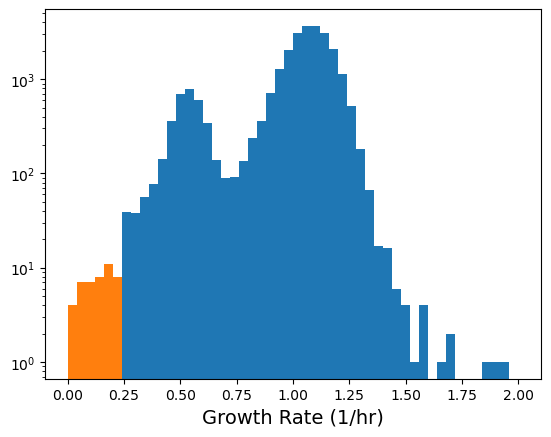

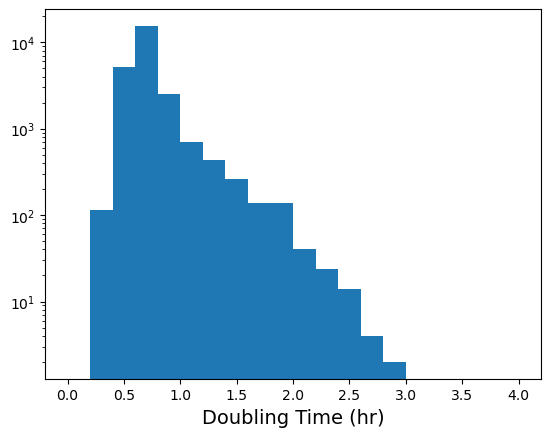

In [15]:
plt.hist(median_growth_rate_series[median_growth_rate_series>growth_rate_threshold],bins=50,log=True,range=(0,2))
plt.hist(median_growth_rate_series[median_growth_rate_series<=growth_rate_threshold],bins=50,log=True,range=(0,2))
plt.xlabel("Growth Rate (1/hr)",fontsize=14)
plt.show()

plt.hist(median_doubling_time_series[median_doubling_time_series<=doubling_time_threshold]/3600,bins=20,log=True,range=(0,4))
plt.hist(median_doubling_time_series[median_doubling_time_series>doubling_time_threshold]/3600,bins=20,log=True,range=(0,4))
plt.xlabel("Doubling Time (hr)",fontsize=14)
plt.show()

In [16]:
frac_proliferating = np.sum(proliferating_trench_df["Proliferating"])/len(proliferating_trench_df)
print(frac_proliferating)

0.9998395249939822


#### Add sgRNA info for real data

In [17]:
strain_dict = {"ftsN":list(range(16)),\
              "glyQ":list(range(16,32)),\
              "rplA":list(range(32,48)),\
              "dnaA":list(range(48,64)),\
              "mrdA":list(range(64,80)),\
              "EV":list(range(80,96))}
inv_strain_dict = {item:key for key,val in strain_dict.items() for item in val}
gene_dict = {"ftsN":9586,\
             "glyQ":7113,\
             "rplA":4754,\
             "dnaA":8869,\
             "mrdA":9865,\
             "EV":29672}

cell_cycle_df["Gene"] = cell_cycle_df["fov"].apply(lambda x: inv_strain_dict[x], meta=str)
cell_cycle_df["oDEPool7_id"] = cell_cycle_df["Gene"].apply(lambda x: gene_dict[x], meta=int)
gene_series = cell_cycle_df.groupby("Multi-Experiment Phenotype Trenchid")["Gene"].first().compute()
sgrnaid_series = cell_cycle_df.groupby("Multi-Experiment Phenotype Trenchid")["oDEPool7_id"].first().compute()

timepoints_df = timepoints_df.join(gene_series)
timepoints_df = timepoints_df.join(sgrnaid_series)

growth_df = growth_df.join(gene_series)
growth_df = growth_df.join(sgrnaid_series)

/home/de64/micromamba/envs/crispri/lib/python3.11/site-packages/dask/dataframe/core.py:7365: FutureWarning: Meta is not valid, `map_partitions` and `map_overlap` expects output to be a pandas object. Try passing a pandas object as meta or a dict or tuple representing the (name, dtype) of the columns. In the future the meta you passed will not work.
  warnings.warn(
/home/de64/micromamba/envs/crispri/lib/python3.11/site-packages/dask/dataframe/core.py:7365: FutureWarning: Meta is not valid, `map_partitions` and `map_overlap` expects output to be a pandas object. Try passing a pandas object as meta or a dict or tuple representing the (name, dtype) of the columns. In the future the meta you passed will not work.
  warnings.warn(


In [18]:
cell_cycle_df_only_proliferating = cell_cycle_df[cell_cycle_df["Proliferating"]]

n_obs_cell_cycle = cell_cycle_df.groupby("oDEPool7_id",sort=False).apply(lambda x: len(x.index.unique()), meta=int).compute()
n_obs_cell_cycle = pd.DataFrame(n_obs_cell_cycle).rename({0:"N Observations"}, axis=1).sort_index()
n_obs_cell_cycle_prolif = cell_cycle_df_only_proliferating.groupby("oDEPool7_id",sort=False).apply(lambda x: len(x.index.unique()), meta=int).compute()
n_obs_cell_cycle_prolif = pd.DataFrame(n_obs_cell_cycle_prolif).rename({0:"N Observations Proliferating"}, axis=1).sort_index()
n_obs_cell_cycle_df = pd.concat([n_obs_cell_cycle,n_obs_cell_cycle_prolif],axis=1)
n_obs_cell_cycle_df.loc[np.isnan(n_obs_cell_cycle_df["N Observations Proliferating"]),"N Observations Proliferating"] = 0
n_obs_cell_cycle_df["N Observations Proliferating"] = n_obs_cell_cycle_df["N Observations Proliferating"].astype(int)
cell_cycle_df = cell_cycle_df.join(n_obs_cell_cycle_df,on="oDEPool7_id")

n_obs_timepoints = timepoints_df.groupby("oDEPool7_id",sort=False).apply(lambda x: len(x.index.unique()), meta=int).compute()
n_obs_timepoints = pd.DataFrame(n_obs_timepoints).rename({0:"N Observations"}, axis=1).sort_index()
timepoints_df = timepoints_df.join(n_obs_timepoints,on="oDEPool7_id")

n_obs_growth = growth_df.groupby("oDEPool7_id",sort=False).apply(lambda x: len(x.index.unique()), meta=int).compute()
n_obs_growth = pd.DataFrame(n_obs_growth).rename({0:"N Observations"}, axis=1).sort_index()
growth_df = growth_df.join(n_obs_growth,on="oDEPool7_id")

/home/de64/micromamba/envs/crispri/lib/python3.11/site-packages/dask/dataframe/core.py:7365: FutureWarning: Meta is not valid, `map_partitions` and `map_overlap` expects output to be a pandas object. Try passing a pandas object as meta or a dict or tuple representing the (name, dtype) of the columns. In the future the meta you passed will not work.
  warnings.warn(
/home/de64/micromamba/envs/crispri/lib/python3.11/site-packages/dask/dataframe/core.py:7365: FutureWarning: Meta is not valid, `map_partitions` and `map_overlap` expects output to be a pandas object. Try passing a pandas object as meta or a dict or tuple representing the (name, dtype) of the columns. In the future the meta you passed will not work.
  warnings.warn(
/home/de64/micromamba/envs/crispri/lib/python3.11/site-packages/dask/dataframe/core.py:7365: FutureWarning: Meta is not valid, `map_partitions` and `map_overlap` expects output to be a pandas object. Try passing a pandas object as meta or a dict or tuple represent

### Determine when cells reach steady state and save intermediate df as a checkpoint

In [21]:
cell_cycle_df_ss = cell_cycle_df[cell_cycle_df["Initial time (s)"]>=steady_state_time]
cell_cycle_df_preinduction = cell_cycle_df[cell_cycle_df["Final time (s)"]<=induction_time]
cell_cycle_df = cell_cycle_df.reset_index().set_index("Multi-Experiment Phenotype Trenchid",sorted=True).repartition(npartitions=400)
cell_cycle_df_ss.to_parquet("/home/de64/scratch/de64/sync_folder/2021-11-12_lDE20_Validation_1/2024-03-24_Steady_State_Cell_Cycle_df/", engine="pyarrow", overwrite=True)
cell_cycle_df_preinduction.to_parquet("/home/de64/scratch/de64/sync_folder/2021-11-12_lDE20_Validation_1/2024-03-24_Preinduction_Cell_Cycle_df/", engine="pyarrow", overwrite=True)

timepoints_df_ss = timepoints_df[timepoints_df["Observation time (s)"]>=steady_state_time]
timepoints_df_preinduction = timepoints_df[timepoints_df["Observation time (s)"]<=induction_time]
timepoints_df = timepoints_df.reset_index().set_index("Multi-Experiment Phenotype Trenchid",sorted=True).repartition(npartitions=400)
timepoints_df_ss.to_parquet("/home/de64/scratch/de64/sync_folder/2021-11-12_lDE20_Validation_1/2024-03-24_Steady_State_Timepoints_df/", engine="pyarrow", overwrite=True)
timepoints_df_preinduction.to_parquet("/home/de64/scratch/de64/sync_folder/2021-11-12_lDE20_Validation_1/2024-03-24_Preinduction_Timepoints_df/", engine="pyarrow", overwrite=True)

growth_df_ss = growth_df[growth_df["Measurement time (s)"]>=steady_state_time]
growth_df_preinduction = growth_df[growth_df["Measurement time (s)"]<=induction_time]
growth_df = growth_df.reset_index().set_index("Multi-Experiment Phenotype Trenchid",sorted=True).repartition(npartitions=400)
growth_df_ss.to_parquet("/home/de64/scratch/de64/sync_folder/2021-11-12_lDE20_Validation_1/2024-03-24_Steady_State_Growth_df/", engine="pyarrow", overwrite=True)
growth_df_preinduction.to_parquet("/home/de64/scratch/de64/sync_folder/2021-11-12_lDE20_Validation_1/2024-03-24_Preinduction_Growth_df/", engine="pyarrow", overwrite=True)
dask_controller.reset_worker_memory()

Done.


In [25]:
dask_controller.shutdown()

Done.


2024-03-24 11:48:20,968 - distributed.deploy.adaptive_core - INFO - Adaptive stop
